In [1]:
import nibabel as nib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Primer on NIfTI
[NIfTI](http://nifti.nimh.nih.gov/) is one of the most common file formats for storing neuroimaging data. We could literally spend an entire week discussing the specifics and peculiarities of NIfTI, but for now I'm just going to cover the few things you need to know to get started working with data contained in NIfTI files (which usually end in `.nii` or `.nii.gz`).

If you're interested in learning more about NIfTI images and how they're handled by NiBabel, I highly recommend [this blog post about the NIfTI format](http://brainder.org/2012/09/23/the-nifti-file-format/) and the [Working with NIfTI images](http://nipy.org/nibabel/nifti_images.html) and page of the NiBabel documentation. [This page on image orientations](http://www.grahamwideman.com/gw/brain/orientation/orientterms.htm) is also required reading to fully understand the details of working with MRI images.

There are three main components of a NIfTI image.

### Header
[The header](http://nipy.org/nibabel/nibabel_images.html#the-image-header) contains metadata about the image, such as image dimensions, data type, and TR.

### Affine
The affine translates between data-space and world-space. If you're not familiar with coordinates and image spaces, check out the [Coordinate systems and affines](http://nipy.org/nibabel/coordinate_systems.html) page of the NiBabel documentation. Chris Gorgolewski has [a nice blog post](http://multiplecomparisons.blogspot.com/2014/12/how-to-convert-between-voxel-and-mm.html) on how to do this translation in a few lines of code.

### Data
The data is the data, usually a multidimensional array, always at least X, Y, Z, and sometimes also T (time). 

## Reading NIfTI Images

Reading NIfTI images with NiBabel is an easy two step process.

### `load()`
First, we use the `load()` function to create a [NiBabel image object](http://nipy.org/nibabel/nibabel_images.html) from a NIfTI file.

In [2]:
epi_image = nib.load('/Users/dlurie/Dropbox/Talks/nibabel_101/subject_01_rest_preproc_mni.nii')

NiBabel images are handy because they let you view information about the image without having to load the entire file into memory. 

For example, we can check and see the voxel dimensions of an image (and if it is a 4D image, how many volumes there are).

In [3]:
epi_image.shape[:-1]

(91, 109, 91)

We could also see what kind of data is stored in the image.

In [4]:
epi_image.get_data_dtype()

dtype('<f8')

### `get_data()`
To access the actual image data, we need to run the `get_data()` function on the image object. This will load the image data into memory. There are ways to access the image data without having to read the entire image into memory, but they are beyond the scope of this tutorial. For more information, [click here](http://nipy.org/nibabel/images_and_memory.html).

In [5]:
epi_data = epi_image.get_data()

The `get_data()` function returns a standard [NumPy multi-dimensional array](http://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html), so you can treat it as you would any other `ndarray`.

## Working With Image Data

### Reshaping
The array returned by `get_data()` will always have at least 3 dimensions, but in most cases it is not necessary to keep this shape while you work with the data. In practice it is often easier to work with a 2D (`n_voxels * n_volumes`) array. This can be done using the standard NumPy `reshape()` function.

In [6]:
epi_data_2d = epi_data.reshape(np.prod(epi_data.shape[:-1]), epi_data.shape[-1])
epi_data_2d.shape

(902629, 120)

### Using Brain Masks
Most of the time, you're not interested in the voxels outside the brain. Non-brain voxels are (almost) always set to zero, and are often collectively referred to as the background of the image. This can be seen as the empty black  or grey space outside the head/brain when viewing MRI images. Because we are only interested in the brain data, it is necessary to ignore the background voxels, and in practice this is done by creating a new array that contains only voxels within a pre-defined brain mask.

Let's load a mask and compare it to our EPI image.

In [7]:
mask_image = nib.load('/Users/dlurie/Dropbox/Talks/nibabel_101/subject_01_func_mask_mni.nii')
mask_data = mask_image.get_data()

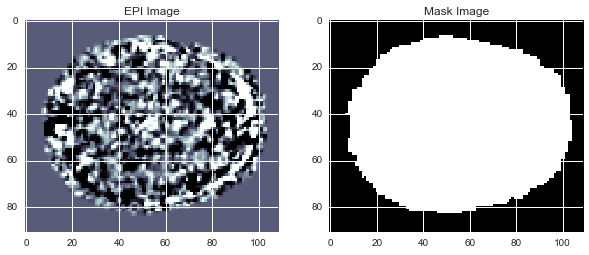

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))                       
ax1.imshow(epi_data[:, :, 50, 90], interpolation='nearest', cmap='bone', vmin="-30", vmax="45")
ax1.set_title('EPI Image')
ax2.imshow(1 - mask_data[:, :, 50], interpolation='nearest')
ax2.set_title('Mask Image')

A brain mask is a NIfTI image with the same dimensions as the brain image to which it will be applied, but instead of voxels of many different intensities, it contains only 0's and 1's. This can also be thought of as an image of True/False values. Because the mask and the brain image are exactly the same shape, every voxel in the data image has a corresponding voxel in the mask. When a mask is applied, voxels in the data image are only included if the corresponding voxel in the mask has a value of 1 (True); all other voxels (those with a value of 0) are excluded. In practice, we are using the mask image to [index](http://docs.scipy.org/doc/numpy/user/basics.indexing.html) the data image.

An added bonus of applying a mask in this way is that your data is automatically reshaped to `n_voxels * n_volumes`. 

First, we load the brain mask and get the data.

In [9]:
mask_image = nib.load('/Users/dlurie/Dropbox/Talks/nibabel_101/subject_01_func_mask_mni.nii')
mask_data = mask_image.get_data()

Then, we make sure the mask data is boolean so that every voxel is either True or False.

In [10]:
mask_data = mask_data.astype(bool)

Once we have our boolean mask, masking the data is as simple as applying an index to an array.

In [11]:
epi_data_masked = epi_data[mask_data]
epi_data_masked.shape

(316636, 120)

We can see that there are fewer voxels per volume in the masked data than the reshaped data, because we have excluded all voxels outside the brain. Now that we have our brain data, we can analyze and manipulate it as we please. For example, we might want to generate an image of the standard deviation of the intensity of a voxel across the whole scan.

In [12]:
std_epi_masked = np.std(epi_data_masked, axis=1)
std_epi_masked.shape

(316636,)

As expected, taking the standard deviation has collapsed across volumes, so we now have an `n_vox * 1` array.

### Unmasking and Creating New Images

Once we have done our analysis, we usually want to save it as a new NIfTI file. If our data is masked, we first have to unmask it. Luckily, this is almost as easy as masking.

First, we create a new empty (all 0's) image array the with the same dimensions as the original data. In this case, although our EPI data was 4D, our standard deviation image is 3D, so we will create an empty 3D array. We pull the image dimensions from the mask (which is 3D), and specify that the empty array should be the same data type as our data.

In [13]:
unmasked_data = np.zeros(mask_data.shape, dtype=std_epi_masked.dtype)
unmasked_data.shape

(91, 109, 91)

Once we have our empty image, we simply apply our mask to the empty image and then copy our mean image to that array.

In [14]:
unmasked_data[mask_data] = std_epi_masked

We can now view our standard deviation image.

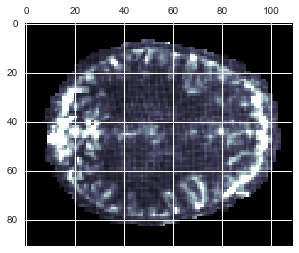

In [15]:
plt.matshow(unmasked_data[:, :, 50], cmap='bone', vmin='0', vmax='111')

## Writing NIfTI Images

Writing NIfTI files is a little bit more complicated than reading them, because we have to pass a NiBabel `nifti1` image object to the `save()` function, and often our data is in a vanilla NumPy array. While it is possible to manually create a new image, header, and affine, I often find it is easier to pull these from an existing image. Here's how I do it.

First, we copy the header and affine from the mask.

In [16]:
mask_header = mask_image.get_header()
mask_affine = mask_image.get_affine()

Since our image data is taken from an image in the same space as the mask, we can use the unmodified affine. However, our data are float, while masks are usually integer, so it is good practice to explicitly set the data type for the new image.

In [17]:
mask_header.set_data_dtype(unmasked_data.dtype)

We now create a new NiBabel `nifti1` image from our data, header, and affine.

In [18]:
sd_img = nib.Nifti1Image(unmasked_data, mask_affine, mask_header)

Once we have our data in an image, saving is easy.

In [19]:
sd_img.to_filename('/Users/dlurie/Dropbox/Talks/nibabel_101/sd_epi_image.nii.gz')